### Water Quality Prediction

In this notebook we are going to continue from the previous notebook, we are going to build models that will classify water potability given certain features.

### Importing Packages

In teh next code cell we are going to import all the packages that we are going to use in this notebook.

In [111]:
import numpy as np 
import pandas as pd

import os
import time
import random
import warnings

from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix, plot_simple_confusion_matrix

from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score, confusion_matrix
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

warnings.filterwarnings("ignore")

print("pandas:", pd.__version__)
print("numpy:", np.__version__)

pandas: 2.1.4
numpy: 1.26.4


### Seeding

Next we are going to set the `seed` to all the random operations that we are going to have in this notebook for reproducivity.

In [5]:
SEED = 7

np.random.seed(SEED)
random.seed(SEED)

### Dataset.

The dataset that we will be using in this notebook was downloaded from the following url:

https://www.kaggle.com/code/imakash3011/water-quality-prediction-7-model

We are going to load the dataset from the file that we saved from the previous notebook.

In [7]:
data_path = 'balanced_df.csv'
dataframe = pd.read_csv(data_path)
dataframe.head()

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
0,7.775386,193.077168,15704.482093,7.881197,324.336203,301.753477,13.378165,89.051957,3.309472,not portable
1,8.184410,166.636554,17944.852375,4.038955,331.954199,363.235756,12.535838,56.310592,4.599082,not portable
2,7.333003,189.447965,32358.538595,6.346378,341.346443,490.625291,12.537466,61.581378,2.642004,not portable
3,4.443239,178.956206,25008.532248,4.948815,298.576676,429.544773,17.729724,56.347689,3.268325,not portable
4,5.345345,238.510230,10315.353973,7.822601,281.771707,496.350875,12.624613,87.342833,2.362886,not portable


### Datset Splitting

The next thing that we are going to do is to create 2 subset from our dataframe which are:

1. ``train``
2. ``test``

> The train dataset is going to be used to ``train`` our algorithm and the ``test`` dataset will be used to evaluate the trained model.

For dataset splitting we are going to use the method from `sklearn.model_selection` called `train_test_split`. We are going to take `20%` of the entire dataset and put it to the test set and the remaining data will be left for the training set.


### Why do we split the data into subsets??

We are splitting our data into two sets which are the train and evaluation set. The reason we are spliting our data into train and test is that we want to train a model using the training data and evaluate the model using the data it haven't seen during it's train which is the test set. So during the training of the model, the model should not have any idea of how our test data so that during evaluation our model will be able to give us reliable matrics. And if we are happy with the metrics which means we have a good chance that the model will perform very well during inference/in production.


In [9]:
train, test = train_test_split(
    dataframe, test_size=0.2, random_state=SEED
)

Next we are going to check how the dataset is distributed using a `piechat` accross these two sets.

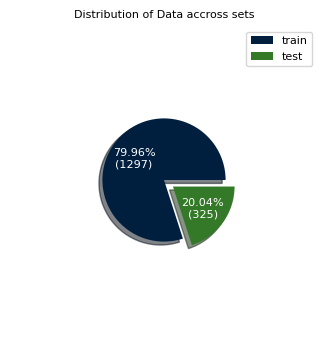

In [13]:
dist_sets = {'train': len(train), 'test': len(test)}

def fmt(x, total):
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)

colors = ['#001F3F', '#347928']

plt.figure(figsize=(4, 4))
plt.title("Distribution of Data accross sets", fontsize=8)
plt.pie(
    dist_sets.values(), labels=dist_sets.keys(), autopct=lambda x: fmt(x, len(dataframe)),
    textprops={'color': 'white', 'fontsize':8}, radius=.5, explode=[.0, .09],
    colors=colors, shadow=True,
)
plt.legend(fontsize=8)
plt.show()

We can see that out of all the data in the dataset, `20%` belongs to the testing data and `80%` belongs to the training data. Now that we have split our data what's next??




### Extract features and labels.
Next we are going to get the train features and labels as well as the test features and labels. Our labels are `text` but our features are numbers. However, machine learning algorithims understand numbers. We need a way of converting these labels into numbers. There are many ways of doing this but in this case i will use the simple one. First i will use the get my labels and use the `LabelEncoder` to change these labels to numbers.


> 🤔 Remember, our features are all the columns expect the `potability` in the dataframe.

In [17]:
train_features = train.drop(["potability"],axis=1)
train_labels = train["potability"].values

test_features = test.drop(["potability"],axis=1)
test_labels = test["potability"].values

In [19]:
train_features.head(2)

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity
1123,6.392928,159.168926,21217.158596,5.298877,317.256788,305.243600,16.865453,62.154379,3.271339
128,7.566517,205.396582,30823.730490,7.816636,354.175972,395.297275,12.095251,63.767702,3.275142


In [21]:
train_labels[:2]

array(['portable', 'not portable'], dtype=object)

In [23]:
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)

LabelEncoder()

In [25]:
train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)

test_labels[:2], train_labels[:2]

(array([1, 0]), array([1, 0]))

You can check the class name by accessing the `classes_` property.

In [27]:
label_encoder.classes_

array(['not portable', 'portable'], dtype=object)

You can also do the reverse transformation from numerical labels to categorical labels using the `inverse_transform` function as follows:

In [29]:
label_encoder.inverse_transform(test_labels[:2])

array(['portable', 'not portable'], dtype=object)

In [31]:
train_features.head()

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity
1123,6.392928,159.168926,21217.158596,5.298877,317.256788,305.243600,16.865453,62.154379,3.271339
128,7.566517,205.396582,30823.730490,7.816636,354.175972,395.297275,12.095251,63.767702,3.275142
383,9.349470,252.148499,13137.490762,6.173823,320.323984,349.816084,13.109898,58.801291,3.778023
359,7.057553,177.674305,13129.149842,7.312352,367.328533,393.740497,16.356320,53.841797,4.486403
739,7.266595,176.853696,14859.059661,8.261778,327.172252,445.037456,19.923704,87.066131,3.357439


Our labels has been endoded or they are now numerical. What's next??


### Scaling Features.


Our feature are number, however they need to be scaled. So we are going to create a pipeline that will work on tranforming our data in the way that we want. We are going to use something called `ColumnTransformer` from sklearn. We are going to encode each column surperately and scale the features in a pipeline. Here are the transformations that we are going to make for our features.

1. ph - `StandardScaler`
2. hardness - `StandardScaler`
3. solids - `StandardScaler`
4. chloramines - `StandardScaler`
5. sulfate - `StandardScaler`
6. conductivity - `StandardScaler`
7. organic_carbon - `StandardScaler`
8. trihalomethanes - `StandardScaler`
9. turbidity - `StandardScaler`


### Refs
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html


In [33]:
scale_pipeline = Pipeline([
  ('standard_scaler', StandardScaler())
])
ct = ColumnTransformer([
        ("pre-processing", scale_pipeline, train_features.columns),
])
train_features_transformed = ct.fit_transform(train_features)
# on the test data we are only going to transform it
test_features_transformed = ct.transform(test_features)

In [35]:
train_features_transformed[0]

array([-0.46602309, -1.13651259, -0.07022575, -1.16302319, -0.38777065,
       -1.48865557,  0.76268881, -0.31441881, -0.89322008])

In [37]:
test_features_transformed[0]

array([ 0.22683284,  0.93881489,  0.54991926, -0.93999853, -0.78775216,
       -1.15786341,  0.52148792, -2.4280871 , -0.12199833])

### Model Selection

In this section we are going to search amoung all the classification algorithim to see which one will perform better for our task. The classification algorithms that we are going to try which are:

1. `LogisticRegression`
2. `DecisionTreeClassifier`
3. `RandomForestClassifier`
4. `SVC`
5. `KNN`

### Refs
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [39]:
train_labels_transformed = train_labels
test_labels_transformed = test_labels

pipeline_lr = Pipeline([('lr_classifier', LogisticRegression(random_state=SEED, max_iter=100))])
pipeline_dt = Pipeline([ ('dt_classifier', DecisionTreeClassifier(random_state=SEED))])
pipeline_rf = Pipeline([('rf_classifier', RandomForestClassifier())])
pipeline_svc = Pipeline([('sv_classifier', SVC())])
pipeline_knn = Pipeline([('knn_classifier', KNeighborsClassifier(n_neighbors=5))])

pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_svc, pipeline_knn]
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest', 3: "SVC", 4: 'KNN'}

for pipe in pipelines:
    pipe.fit(train_features_transformed, train_labels_transformed)

Next we are going to calculate the `cross_validation_score` among our classification models and see which classification algorithm does perform better based on our data.

In [41]:
cv_results_accuracy = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, test_features_transformed, test_labels_transformed, cv=10 )
    cv_results_accuracy.append(cv_score)
    print("%s: %f \t" % (pipe_dict[i], cv_score.mean()))

Logistic Regression: 0.485795 	
Decision Tree: 0.587311 	
RandomForest: 0.558807 	
SVC: 0.606061 	
KNN: 0.554072 	


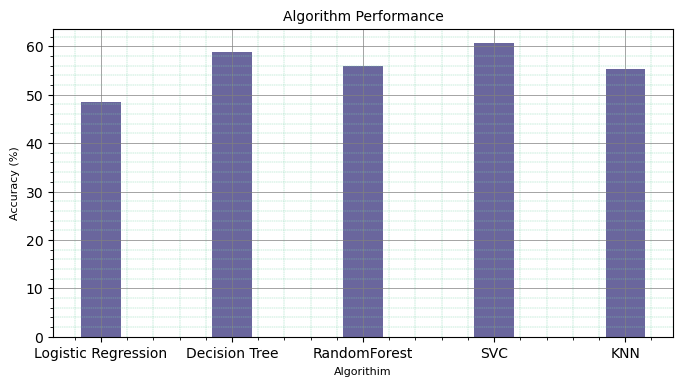

In [81]:
rev = {v: cv_results_accuracy[i].mean() * 100 for i, (k, v) in enumerate(pipe_dict.items())}

plt.figure(figsize=(8, 4))
plt.bar(rev.keys(), rev.values(), width=.3, color="#6A669D")

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.ylabel("Accuracy (%)", fontsize=8)
plt.xlabel("Algorithim", fontsize=8)
plt.title("Algorithm Performance", fontsize=10)
plt.show()


We can see among all the algorithms, the `SVC` has better cross validation score than the others. We are going to use that to build our model that we will evaluate. But before we do that we want to use the `GridSearchCV` to find the best parameters that we can pass to our `SVC` classifier.

### Refs

- https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [83]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10], 'gamma': ['scale', 'auto', 1.] }
classifier = SVC()
gs = GridSearchCV(classifier, parameters)
gs.fit(train_features_transformed, train_labels_transformed)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'gamma': ['scale', 'auto', 1.0],
                         'kernel': ('linear', 'rbf')})

In [85]:
gs.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [89]:
model = SVC(**gs.best_params_)
model.fit(train_features_transformed, train_labels_transformed)

SVC(C=1)

### Evaluating model

Next we are going to evaluate our model.

In [91]:
model.score(train_features_transformed, train_labels_transformed)

0.7602158828064765

In [93]:
model.score(test_features_transformed, test_labels_transformed)

0.6184615384615385

### Classifier Performance
In this section we are going to have a look on how well our classifier model will be performing interms of the following metrics.

1. Confusion Matrix
2. Precision
3. Recall
4. F1 Score

### F1 Score
F1 score is a machine learning evaluation metric that measures a model's accuracy. It combines the precision and recall scores of a model. The accuracy metric computes how many times a model made a correct prediction across the entire dataset.


First let's make predictions for all our 2 sets, train and test.

In [95]:
# predicted labels
train_preds = model.predict(train_features_transformed)
test_preds = model.predict(test_features_transformed)

# real labels
y_train = train_labels_transformed
y_test = test_labels_transformed

We can check the first 10 predicted labels as follows.

In [97]:
train_preds[:10]

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 0])

In [99]:
y_train[:10]

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 0])

Now we can calculate the ``f1_scores`` for each label in from the train set as follows:

In [101]:
classes = label_encoder.classes_
train_score = f1_score(y_train, train_preds, labels=np.array([0, 1]), average=None)
test_score = f1_score(y_test, test_preds, labels=np.array([0, 1]), average=None)

print("Train F1-Score: \t", list(zip(train_score, classes)))
print("Test F1-Score: \t", list(zip(test_score, classes)))

Train F1-Score: 	 [(0.7786476868327401, 'not portable'), (0.7384356602186711, 'portable')]
Test F1-Score: 	 [(0.6416184971098265, 'not portable'), (0.5921052631578947, 'portable')]


### Precision Score
Precision score measures the proportion of positively predicted labels that are actually correct. Precision is also known as the positive predictive value. Let's check the precision score of our model based on our examples in each set.

In the train set the precision score are as follows:

In [103]:
train_score = precision_score(y_train, train_preds, labels=np.array([0, 1]), average=None)
test_score = precision_score(y_test, test_preds, labels=np.array([0, 1]), average=None)

print("Train Precision: \t", list(zip(train_score, classes)))
print("Test Precision: \t", list(zip(test_score, classes)))

Train Precision: 	 [(0.7206851119894598, 'not portable'), (0.8159851301115242, 'portable')]
Test Precision: 	 [(0.6132596685082873, 'not portable'), (0.625, 'portable')]


### Recall Score

Recall is the true positive rate, also referred to as sensitivity, which measures the probability of ground truth objects being correctly detected. Similarly, Recall ranges from 0 to 1, where a high recall score means that most ground truth objects were detected.

In [105]:
train_score = recall_score(y_train, train_preds, labels=np.array([0, 1]), average=None)
test_score = recall_score(y_test, test_preds, labels=np.array([0, 1]), average=None)

print("Train Precision: \t", list(zip(train_score, classes)))
print("Test Precision: \t", list(zip(test_score, classes)))

Train Precision: 	 [(0.846749226006192, 'not portable'), (0.674347158218126, 'portable')]
Test Precision: 	 [(0.6727272727272727, 'not portable'), (0.5625, 'portable')]


### Accuracy Score
Though this is not a good measure of how our model is performing when unbalanced examples for each label. However in our dataset our examples have labels that are close to balanced and we can use this metric to measure the model performance. The accuracy score can be caluculated as follows:



In [107]:
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Train Acc: \t", train_accuracy)
print("Test Acc: \t", test_accuracy)

Train Acc: 	 0.7602158828064765
Test Acc: 	 0.6184615384615385


### Classification Report.

The classification report visualizer displays the `precision`, `recall`, `F1`, and support scores for the model. Let's display the classification report for each set.

Let's print the classification report based on the train predictions.

In [109]:
cr = classification_report(y_train, train_preds, output_dict=False, target_names = classes)
print(cr)

              precision    recall  f1-score   support

not portable       0.72      0.85      0.78       646
    portable       0.82      0.67      0.74       651

    accuracy                           0.76      1297
   macro avg       0.77      0.76      0.76      1297
weighted avg       0.77      0.76      0.76      1297



In [56]:
cr = classification_report(y_test, test_preds, output_dict=False, target_names = classes)
print(cr)

              precision    recall  f1-score   support

not portable       0.61      0.67      0.64       165
    portable       0.62      0.56      0.59       160

    accuracy                           0.62       325
   macro avg       0.62      0.62      0.62       325
weighted avg       0.62      0.62      0.62       325



### Confusion Matrix
Next we are going to plot the confusion matrix and visually see how well our model is performing in predicting load shedding impact given some features and how confused it is between these different classes. 

In [59]:
cm = confusion_matrix(y_train, train_preds)
print(cm)

[[547  99]
 [212 439]]


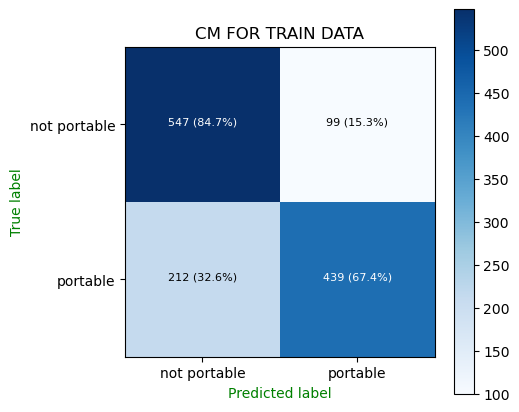

In [60]:
plot_complicated_confusion_matrix(y_train, train_preds,
  classes, fontsize=8, figsize=(5, 5), title="CM FOR TRAIN DATA"
)

In [117]:
cm = confusion_matrix(y_test, test_preds)
print(cm)

[[111  54]
 [ 70  90]]


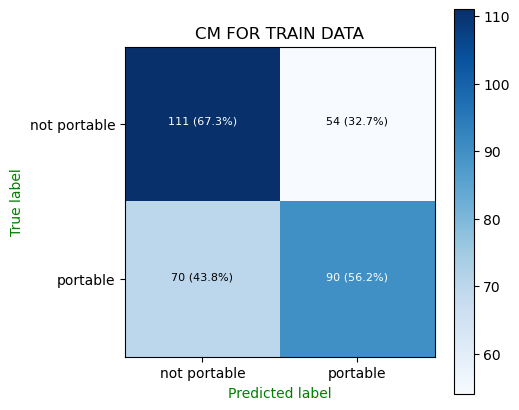

In [119]:
plot_complicated_confusion_matrix(y_test, test_preds,
  classes, fontsize=8, figsize=(5, 5), title="CM FOR TRAIN DATA"
)

Next we are going to have a look at how we can improve our model using `PCA` and some other methods.